# Main

## Initialization

Retrieves the dependencies:
- [segmentation models](https://github.com/qubvel/segmentation_models)

In [1]:
#!pip uninstall -qy keras tensorflow
#!pip uninstall -qy h5py numpy opencv-python
#!pip install -qU keras tensorflow
#!pip install -qU opencv-python "numba<0.49" "numpy<19.0" "h5py<2.11" backports.cached-property imgaug keras-segmentation scikit-learn "matplotlib~=3.2.0" keras-unet "imgaug>=0.4.0" "tornado>5.1" pynvml
#!pip install -q keras==2.3.1 tensorflow==2.1.0 keras_applications==1.0.8 image-classifiers==1.0.0 efficientnet==1.0.0 gast==0.3.2 tensorboard==2.3.0
!pip install -q segmentation_models

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
%env SM_FRAMEWORK=tf.keras

import json
import os
import pathlib

from datetime import datetime
from enum import Enum
from glob import glob
from math import ceil
from dataclasses import dataclass, field

import numpy as np
import sklearn as sk
import sklearn.model_selection
import cv2 as cv
import tensorflow as tf
import tensorflow.keras as kr
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
import segmentation_models as sm

from typing import Tuple, List, Dict, Any, Callable, Union, Iterator, Iterable

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
print("tensorflow version: {}".format(tf.__version__))
print("keras version: {}".format(kr.__version__))
print("available gpu: {}".format(tf.test.gpu_device_name()))

tensorflow version: 2.3.1
keras version: 2.4.0
available gpu: /device:GPU:0


Sets SEED to avoid randomness into dataset generator

In [4]:
SEED = abs(hash("cookies")) // 2**32
tf.random.set_seed(SEED)
np.random.seed(SEED)

Defines the experiment configuration

In [5]:
EXPERIMENT_NAME = "densenet121_tilling_256"
BACKBONE = "densenet121"
PREPROCESSING_MASK_LIMITS_HSV = ((30,40,70), (80,255,255))
IMAGES_PER_BATCH = 4
INPUT_SIZE = (256,256)
IMAGE_SUBSET = (3, 4)
EPOCHS = 15

In [6]:
EXPERIMENT ="{}_{}".format(datetime.now().strftime("%m-%d_%H-%M"), EXPERIMENT_NAME)

Defines base path

In [7]:
PATH_DATA = pathlib.Path("/kaggle/input/") / "rose-eval-2019"

PATH_WORKING = pathlib.Path("/kaggle/working")

PATH_TRAINING = PATH_DATA / "training"
PATH_TEST = PATH_DATA / "test"

PATH_EXPERIMENT = PATH_WORKING / EXPERIMENT

PATH_SUBMISSION = PATH_EXPERIMENT /  "submission.json"
PATH_SUBMISSION_ZIP = PATH_EXPERIMENT /  "{}.zip".format(EXPERIMENT)

In [8]:
os.makedirs(PATH_EXPERIMENT, exist_ok=True)

Cretes images list for the dataset

In [9]:
# defines the images' paths
PATHS_TRAINING_IMAGES = [
    *list((PATH_TRAINING).rglob("**/Images/*")),
    #*list((PATH_TRAINING / "Bipbip").rglob("*/Images/*")),
    #*list((PATH_TRAINING / "Weedelec").rglob("*/Images/*"))
    #*list((PATH_TRAINING / "Bipbip" / "Mais" / "Images").rglob("*")),
    #*list((PATH_TRAINING / "Roseau" / "Mais" / "Images").rglob("*")),
    #*list((PATH_TRAINING / "Weedelec" / "Mais" / "Images").rglob("*"))
]

# retieves the corresponding masks' paths
PATHS_TRAINING_MASKS = [f.parents[1] / "Masks" / (f.stem + ".png") for f in PATHS_TRAINING_IMAGES]

# retrieves test images
PATHS_TEST = [
    *list(PATH_TEST.rglob("*.jpg")),
    *list(PATH_TEST.rglob("*.png"))
]

print("Found {} training images".format(len(PATHS_TRAINING_IMAGES)))
print("Found {} test images".format(len(PATHS_TEST)))

Found 720 training images
Found 120 test images


### Utility

In [10]:
mpl.rcParams['image.cmap'] = 'gray'
def show(*args):
    """
    Showes input images in one row
    """
    s = 10
    _, axs = plt.subplots(1, len(args), figsize=(s*len(args),s*1.6))
    
    for i in range(len(args)):
        axs[i].imshow(args[i])
    plt.show()

def rescale(image):
    """
    Rescales an image in a viewable image
    ex. [-1.,1.] -> [0.,1.]
    """
    mi, ma =  np.min(image), np.max(image)
    
    image = (image - mi) * 1. / (ma-mi)
    
    return image

In [11]:
import time
class Timer:
    """
    Utility to test code speed
    """
    def __init__(self):
        self._begin = 0.
        self._last = 0.
    def start(self):
        self._begin = time.perf_counter()
        self._last = self._begin
        return self
    def check(self):
        l, self._last = self._last, time.perf_counter()
        return self._last - l
    def pcheck(self, name="from last checkpoint"):
        print("{} {}s".format(name,self.check()))

## Dataset

### Dataset tools

In [12]:
@dataclass
class ImageMeta:
    """
    Class to store image metadata
    """
    index: int
    path: pathlib.Path
    original_size: Tuple[int, int]
    subset_amount: Tuple[int, int]
    resized_size: Tuple[int, int] = None
    subset_size: Tuple[int, int] = None
    subsets: List[Tuple[int, int, int, int]] = field(init=False)

    def __post_init__(self):
        if self.resized_size is None:
            self.resized_size = (self.subset_size[0] * self.subset_amount[0],self.subset_size[1] * self.subset_amount[1])
        elif self.subset_size is None:
            self.subset_size = (self.subset_size[0] // self.subset_amount[0],self.subset_size[1] // self.subset_amount[1])
        
        # generates the subsets for the patches
        self.subsets = [(
            y*self.subset_size[0], (y+1)*self.subset_size[0],
            x*self.subset_size[1], (x+1)*self.subset_size[1]
        )for y in range(self.subset_amount[0]) for x in range(self.subset_amount[1])]

In [13]:
class CustomDataset(tf.keras.utils.Sequence):
    _seed = SEED

    def __init__(self,
                 paths_images: List[str],
                 paths_masks: List[str] = None,
                 image_data_generator_options: Dict = None,
                 preprocessing_function: Callable[[np.array], np.array] = lambda x: x,
                 postprocessing_function: Callable[[np.array], np.array] = lambda x: x,
                 mask_decoding_function: Callable[[np.array], np.array] = lambda x: x,
                 image_size: Tuple[int, int] = (256, 256),
                 images_per_batch: int = 1,
                 image_subset: Tuple[int,int] = (1,1),
                 shuffle: bool = False
                ):
        '''
        :param paths_images: A list of images' paths
        :param paths_masks: The list of corresponding masks' paths or None if this is a prediction dataset
        :param image_data_generator_options: The configuration for augmetnation generator
        :param preprocessing_function: The preprocessing function is applies to the images before augumentation and resizing phases
        :param postprocessing_function: The postprocessing function is applies to the images after the augmentation and resizing phases
        :param mask_decoding_function: The decoding function is used to deconding mask files
        :param image_size: The size of the output patches
        :param images_per_batch: The number of images per batch, with 0 the batch will contain the whole dataset
        :param image_subset: The number of the rows and columns to split images
        :param shuffle: If it is True at each epoch the data are shuffled
        '''
        self._paths_images = paths_images
        self._paths_masks = paths_masks
        self._preprocessing_function = preprocessing_function
        self._postprocessing_function = postprocessing_function
        self._mask_decoding_function = mask_decoding_function
        self._images_per_batch = images_per_batch
        self._image_size = image_size
        self._image_subset = image_subset
        self._shuffle = shuffle
        
        self._transform_generator = self._get_transform_generator()
        
        # creates the list of the images indexes
        self._indexes = np.arange(len(paths_images))
        # shuffles them if required
        if self._shuffle:
            np.random.shuffle(self._indexes)
        
        self._image_data_generator = None
        self._mask_data_generator = None
        if image_data_generator_options is not None:
            # creates a new generator for image augmentation
            self._image_data_generator = kr.preprocessing.image.ImageDataGenerator(**image_data_generator_options)
            # for mask generator remove the fill_mode to prevent creation of fake element in the mask
            image_data_generator_options["fill_mode"]="nearest"
            self._mask_data_generator = kr.preprocessing.image.ImageDataGenerator(**image_data_generator_options)
        
        # creates an empty list for the images metadata
        self._images_meta = [None for _ in self._paths_images]

    def __len__(self):
        if self._images_per_batch == 0:
            return 1
        
        return ceil(len(self._paths_images) / self._images_per_batch)

    def __getitem__(self, batch_index: int) -> Union[np.array, Tuple[np.array, np.array]]:
        batch_images=[]
        batch_masks=[]
        
        # retrieves the subset of the images in the batch
        batch_indexes = self._indexes if self._images_per_batch == 0 else self._indexes[batch_index * self._images_per_batch:(1 + batch_index) * self._images_per_batch]
        
        for i in batch_indexes:
            if len(self._indexes) <= i:
                break
            
            # gets the i-th image and mask patches 
            images, masks = self._get_data(i)
            
            batch_images += images
            
            if masks is not None:
                batch_masks += masks
        
        # returns only the image batch if this is a prediction dataset
        if self._paths_masks is None:
            return np.array(batch_images)
        
        return np.array(batch_images), np.array(batch_masks)
    
    def _get_data(self, index: int) -> Tuple[np.array, Union[np.array, None]]:        
        # loads the image from file
        image = plt.imread(self._paths_images[index], np.uint8)
        
        # retrieves meta data for the image
        if self._images_meta[index] is None:
            self._images_meta[index] = ImageMeta(index, self._paths_images[index],
                                                 original_size=image.shape[0:2],
                                                 subset_size=self._image_size,
                                                 subset_amount=self._image_subset)
        meta = self._images_meta[index]
        
        # resizes image
        image = cv.resize(image, meta.resized_size[::-1], cv.INTER_LINEAR)
        
        # applies the preprocessing function to the image
        image = self._preprocessing_function(image)

        transf_image, transf_mask = None, None
        if self._image_data_generator is not None:
            # gets a transformation
            transf_image, transf_mask = next(self._transform_generator)

            # applies the transformation to mask and image
            image = self._image_data_generator.apply_transform(image, transf_image)
        
        # applies postprocessing function to the image
        image = self._postprocessing_function(image)
        
        # splits image in patches
        subset_images = []
        for (y0,y1,x0,x1) in meta.subsets:
            subset_images.append(image[y0:y1,x0:x1])
        
        # if this is a prediction dataset skips the processing of the mask
        if self._paths_masks is None:
            return subset_images, None
        
        # loads the mask from file
        mask = plt.imread(self._paths_masks[index], np.uint8)
        
        # decodes the mask
        mask = self._mask_decoding_function(mask)
        
        # resizes the mask
        mask = cv.resize(mask, meta.resized_size[::-1], interpolation=cv.INTER_NEAREST)
        
        if transf_mask is not None:
            # applies the transformation to mask
            mask = self._mask_data_generator.apply_transform(mask, transf_mask)
            
            # removes the error given by interpolation
            mask = np.round(mask)
        
        # splits the mask into patches
        subset_masks = []
        for (y0,y1,x0,x1) in meta.subsets:
            subset_masks.append(mask[y0:y1,x0:x1])
        
        return subset_images, subset_masks
    
    def on_epoch_end(self) -> None:
        # at each epoch end shuffles the images if required 
        if self._shuffle:
            np.random.shuffle(self._indexes)

    def _get_transform_generator(self):
        # retrives a pseudo-random transformation from a generator for images and masks
        while True:
            yield (self._image_data_generator.get_random_transform(self._image_size, seed=CustomDataset._seed), 
                    self._mask_data_generator.get_random_transform(self._image_size, seed=CustomDataset._seed))
            CustomDataset._seed += 1

In [14]:
class MaskDecoding:
    """
    Provides the function to decode mask files
    """
    def __init__(self, include_ground: bool = True, merge_channels: bool = False):
        """
        :param include_ground: If True create a channel (the last) also fo the background
        :param merge_channels: if True use the sparse categories codification else use one-hot codification
        """
        
        self._include_ground = include_ground
        self._merge_channels = merge_channels
        
        assert (not (self._include_ground and self._merge_channels)), "include_ground and merge_channels both True will not give the expected result"
        
    def __call__(self, mask: np.array) -> np.array:
        # finds the pixels for crop and weed
        channels = [
            np.all(mask==[255,255,255],axis=2)[...,np.newaxis],
            np.all(mask==[216, 67, 82],axis=2)[...,np.newaxis]
        ]
        
        # if required creates a channel also for the background (include also the other channel) 
        if self._include_ground:
            channels += [np.logical_or(np.all(mask==[0,0,0],axis=2), np.all(mask==[254,124,18],axis=2))[:,:,np.newaxis]]
        
        # create a single matrix with all the channels
        mask = np.concatenate(channels, axis=2)
        
        # if required merges all the channels in one, with an unique value for each original channel
        if self._merge_channels:
            # generates a new array with the same size of the original mask 
            new_mask = np.zeros((*mask.shape[0:2],1), dtype=np.float)

            # adds channels to new array on a single channel
            for i in range(mask.shape[-1]):
                new_mask[:,:,0] += mask[:,:,i] * (i + 1)

            mask = new_mask

        return mask.astype(dtype=np.float32)

In [15]:
def preprocessing_image(image: np.array) -> np.array:
    """
    This function provide a simplified version of giveng image, removing a lot of background, not necessaried for the classification
    """
    # changes the space color to hsv
    image_hsv = cv.cvtColor(image.astype(np.uint8), cv.COLOR_RGB2HSV)

    # filters the target color in the hsv space
    designed_mask = cv.inRange(image_hsv, *PREPROCESSING_MASK_LIMITS_HSV)

    # removes the small artifcat in the mask
    denoised_mask = cv.morphologyEx(designed_mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT, (7,7)))

    # expands the target areas
    dilatated_mask = cv.dilate(denoised_mask, np.ones((11,11),np.uint8), iterations = 5)

    # removes all the not targeted content in the image
    image_masked = cv.bitwise_and(image, image, mask = dilatated_mask)

    return image_masked

### Dataset generation

In [16]:
# retirieves the prprocessing function for the net
preprocessing_function = sm.get_preprocessing(BACKBONE)

# defines a set of images augmention rules
generator_options = dict(
                rotation_range=20,
                zoom_range=0.15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.15,
                horizontal_flip=True,
                fill_mode="constant"
            )

# splits training and validation set
dataset = sk.model_selection.train_test_split(PATHS_TRAINING_IMAGES,
                                              PATHS_TRAINING_MASKS,
                                              test_size=0.2,
                                              random_state=SEED)

# creates the training and validation dataset
ds_training = CustomDataset(
    dataset[0],
    dataset[2],
    image_data_generator_options=generator_options,
    preprocessing_function=preprocessing_image,
    postprocessing_function=preprocessing_function,
    mask_decoding_function=MaskDecoding(include_ground=True),
    image_size=INPUT_SIZE,
    images_per_batch=IMAGES_PER_BATCH,
    image_subset=IMAGE_SUBSET,
    shuffle=True
)
ds_validation = CustomDataset(
    dataset[1],
    dataset[3],
    image_data_generator_options=generator_options,
    preprocessing_function=preprocessing_image,
    postprocessing_function=preprocessing_function,
    mask_decoding_function=MaskDecoding(include_ground=True),
    image_size=INPUT_SIZE,
    images_per_batch=IMAGES_PER_BATCH,
    image_subset=IMAGE_SUBSET,
    shuffle=True
)

# creates the test dataset
ds_test = CustomDataset(
    PATHS_TEST,
    preprocessing_function=preprocessing_image,
    postprocessing_function=preprocessing_function,
    image_size=INPUT_SIZE,
    images_per_batch=IMAGES_PER_BATCH,
    image_subset=IMAGE_SUBSET,
)

print("{} images for training".format(len(dataset[0])))
print("{} images for validation".format(len(dataset[1])))
print("{} images to test".format(len(PATHS_TEST)))

576 images for training
144 images for validation
120 images to test


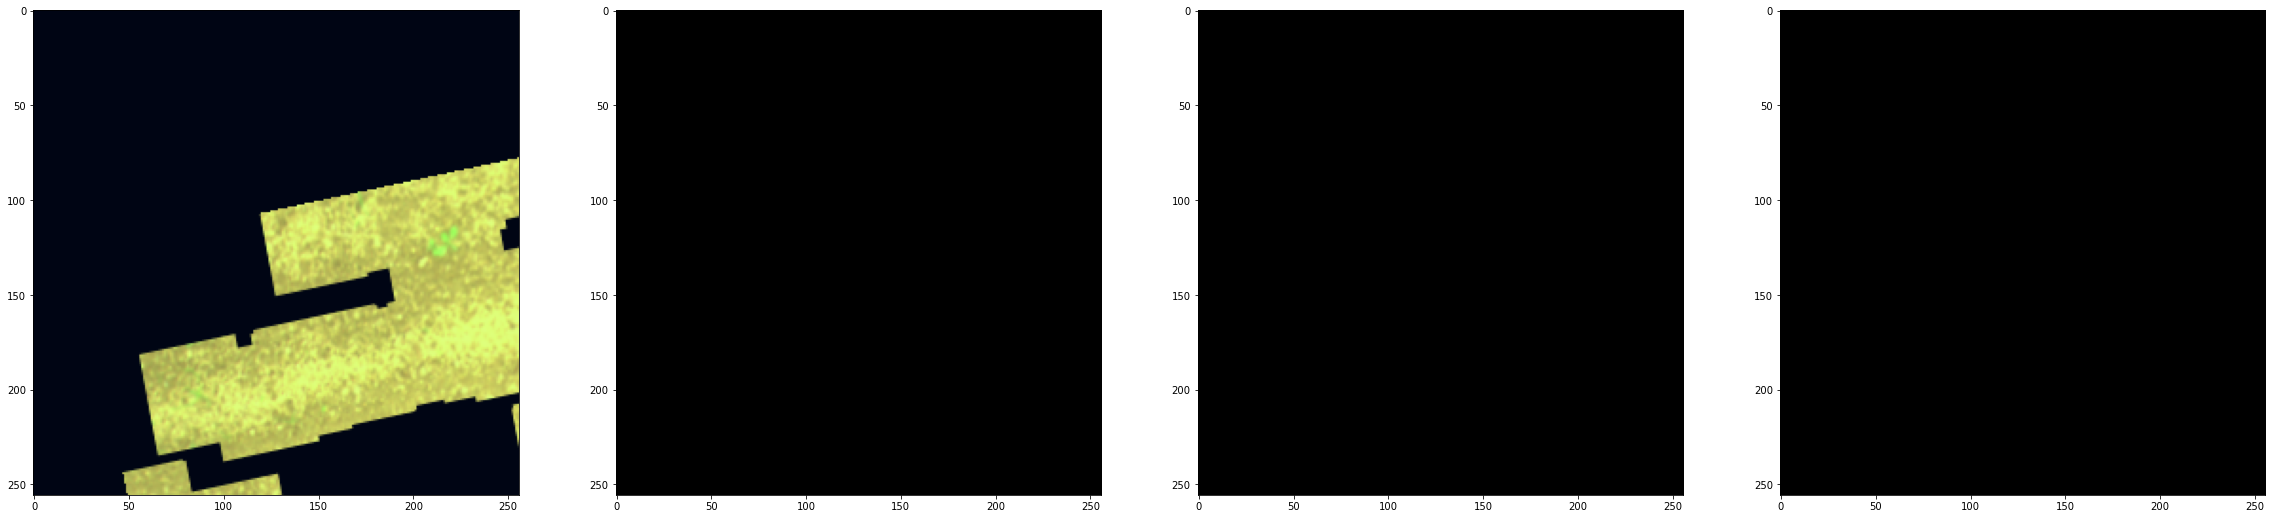

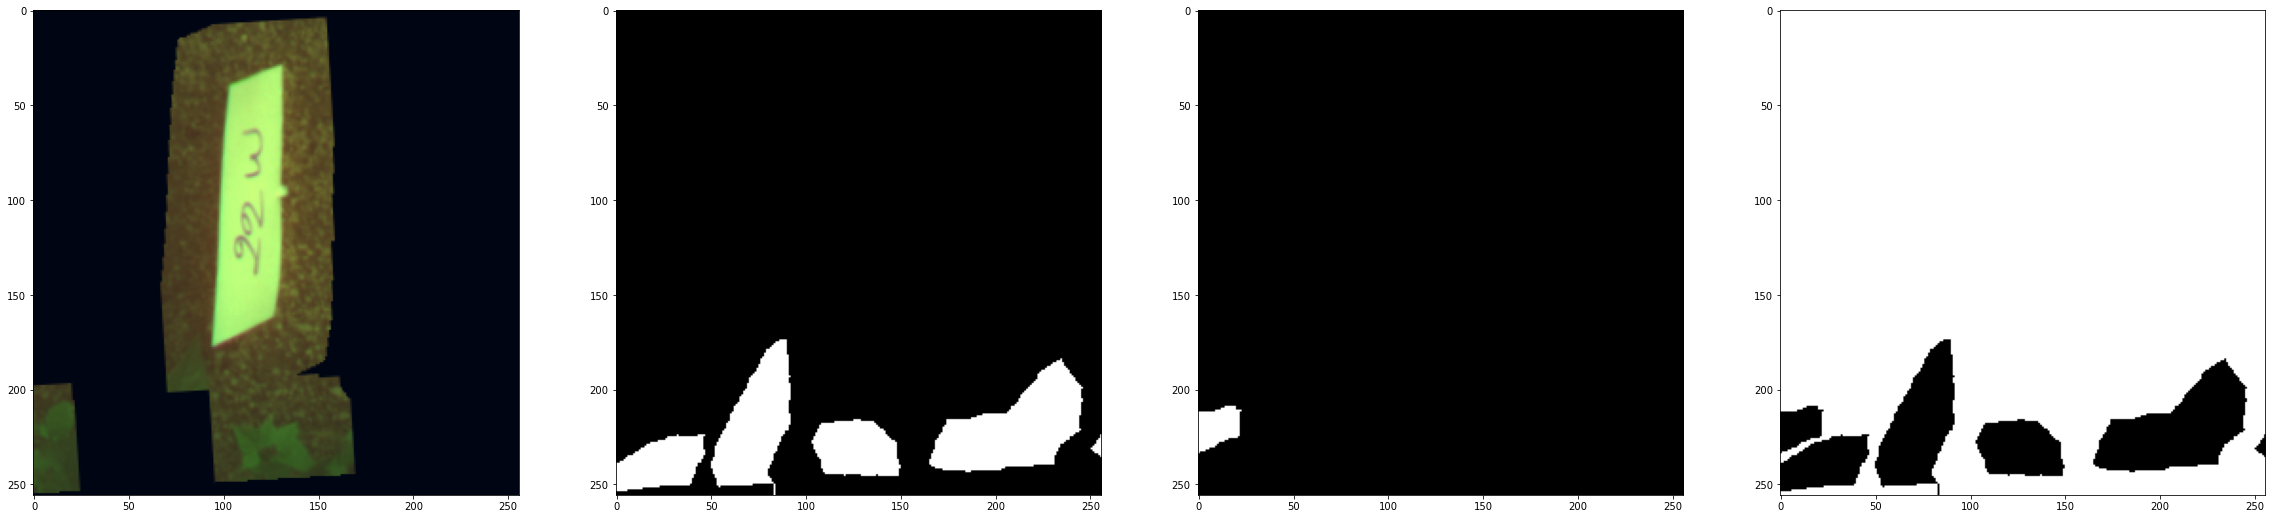

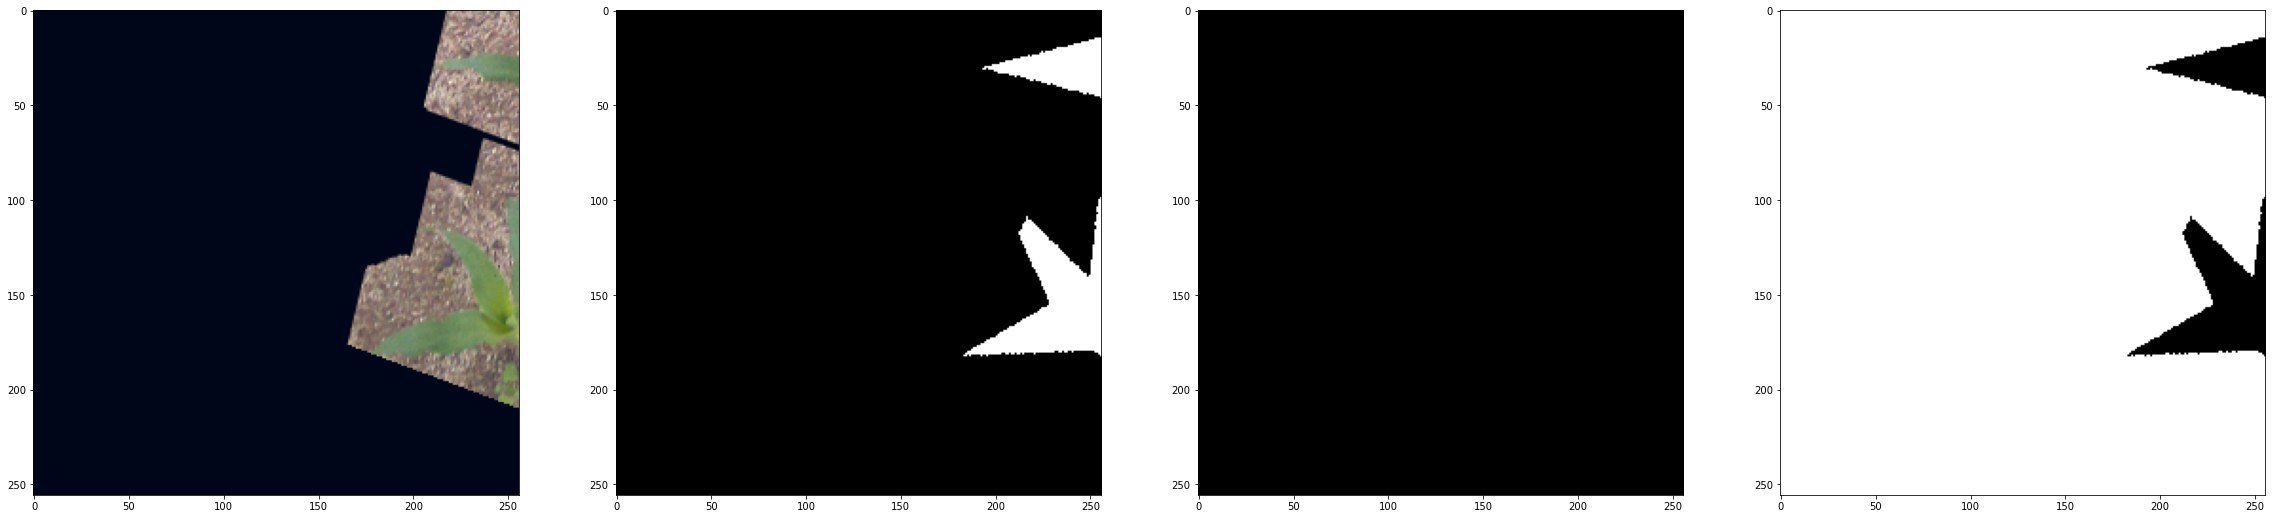

In [17]:
images, masks = ds_training[0]
for i in np.random.choice(images.shape[0], 3):
    show(rescale(images[i]), masks[i,...,-3], masks[i,...,-2], masks[i,...,-1])

## Model

### Definition callbacks

In [18]:
def get_callbacks(
                  save_model: bool = True,
                  checkpoints: bool = False,
                  tensorboard: bool = True,
                  early_stopping: bool = True
                  ) -> List[kr.callbacks.Callback]:
    """
    Returns a list of desidered callbacks for the fit process
    """
    callbacks = []
    
    if save_model:
        os.makedirs(PATH_EXPERIMENT / "model", exist_ok=True)
        callbacks.append(kr.callbacks.ModelCheckpoint(str(PATH_EXPERIMENT / "model"), save_best_only=True, mode='min'))

    if checkpoints:
        # if they are requesed, checkpoints will be saved in a specific experiment subdirecotry
        os.makedirs(PATH_EXPERIMENT / "checkpoints", exist_ok=True)

        callbacks.append(kr.callbacks.ModelCheckpoint(
            str(PATH_EXPERIMENT / "checkpoints" / "cp-{epoch:04d}.ckpt")
        ))

    if tensorboard:
        # if they are required, tensorboard files will be generated
        os.makedirs(PATH_EXPERIMENT / "tb_log", exist_ok=True)

        callbacks.append(kr.callbacks.TensorBoard(
            PATH_EXPERIMENT / "tb_log",
            histogram_freq=1,
            profile_batch=0
        ))
    if early_stopping:
        callbacks.append(kr.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ))

    return callbacks

### Creation of the model

In [19]:
# retrieves a trained model form Segmentation_models module
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=3, activation="softmax", input_shape=(*INPUT_SIZE, 3))

# define optimizer
optim = kr.optimizers.Adam(1e-4)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (crop: 1.; weed: 1.; background: .25;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1., 1., 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# defines the metrics, we only need meanIOU for the first two categories that the sm module provides 
metrics = [
    sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1])
]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________

### Training

In [20]:
# starts the model training
training_history = model.fit(
    ds_training,
    validation_data=ds_validation,
    epochs=EPOCHS,
    callbacks=get_callbacks()
)

Epoch 1/15
144/144 [==============================] - 1428s 10s/step - loss: 0.7515 - iou_score: 0.4085 - val_loss: 0.7655 - val_iou_score: 0.3589
Epoch 2/15
144/144 [==============================] - 1322s 9s/step - loss: 0.5609 - iou_score: 0.5763 - val_loss: 0.5381 - val_iou_score: 0.5753
Epoch 3/15
144/144 [==============================] - 1316s 9s/step - loss: 0.4702 - iou_score: 0.6229 - val_loss: 0.4882 - val_iou_score: 0.5807
Epoch 4/15
144/144 [==============================] - 1326s 9s/step - loss: 0.4315 - iou_score: 0.6505 - val_loss: 0.4477 - val_iou_score: 0.6175
Epoch 5/15
144/144 [==============================] - 1350s 9s/step - loss: 0.4244 - iou_score: 0.6509 - val_loss: 0.4347 - val_iou_score: 0.6309
Epoch 6/15
144/144 [==============================] - 1349s 9s/step - loss: 0.4124 - iou_score: 0.6635 - val_loss: 0.4344 - val_iou_score: 0.6215
Epoch 7/15
144/144 [==============================] - 1351s 9s/step - loss: 0.4092 - iou_score: 0.6671 - val_loss: 0.4297 -

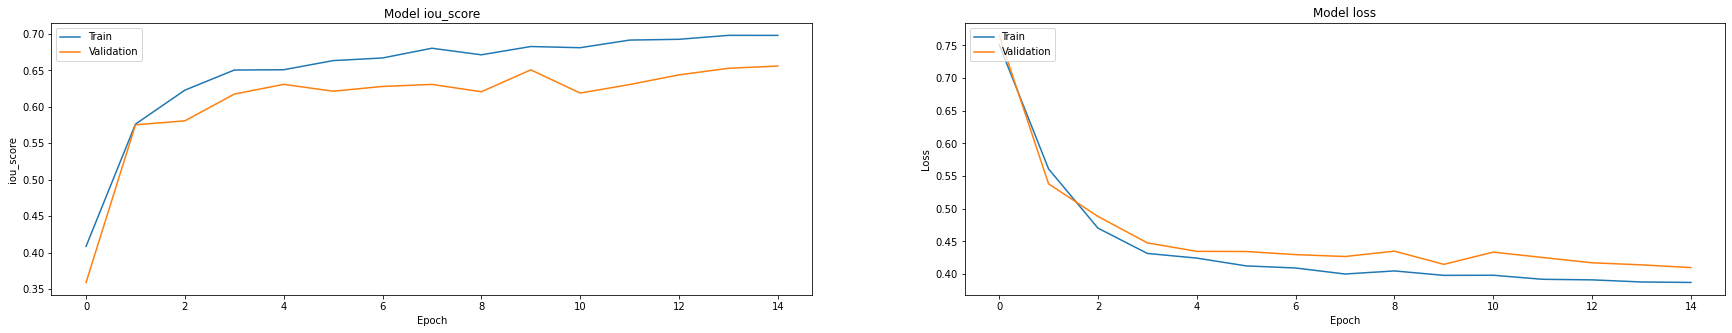

In [21]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(training_history.history['iou_score'])
plt.plot(training_history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Submission

### Prediction

In [22]:
# computes the prediction exploiting the trained model
test_output = model.predict(ds_test)

### Prediction processing

In [23]:
# find the category with highest score for each pixel
prediction = np.argmax(test_output,axis=-1)

# recompose the 3 channels with no intersection and only 0. and 1.
prediction = np.concatenate((
    np.array(prediction == 0, dtype=np.uint8)[...,np.newaxis],
    np.array(prediction == 1, dtype=np.uint8)[...,np.newaxis],
    np.array(prediction == 2, dtype=np.uint8)[...,np.newaxis]
), axis=-1)

### Prediction recomposition

The predition tiles have to been recomposed in the shape of the original image

In [24]:
prediction_iter=iter(list(prediction))
recomposed_prediction=[]

# for each images in the test dataset get the masks tiles and recomposed them in the original image shape
for index in ds_test._indexes:
    meta = ds_test._images_meta[index]
    
    masks=np.full((*meta.resized_size, 3), (0,0,0), dtype=np.uint8)
    
    for (y0,y1,x0,x1) in meta.subsets:
        masks[y0:y1,x0:x1] = next(prediction_iter)
    
    recomposed_prediction.append(masks)

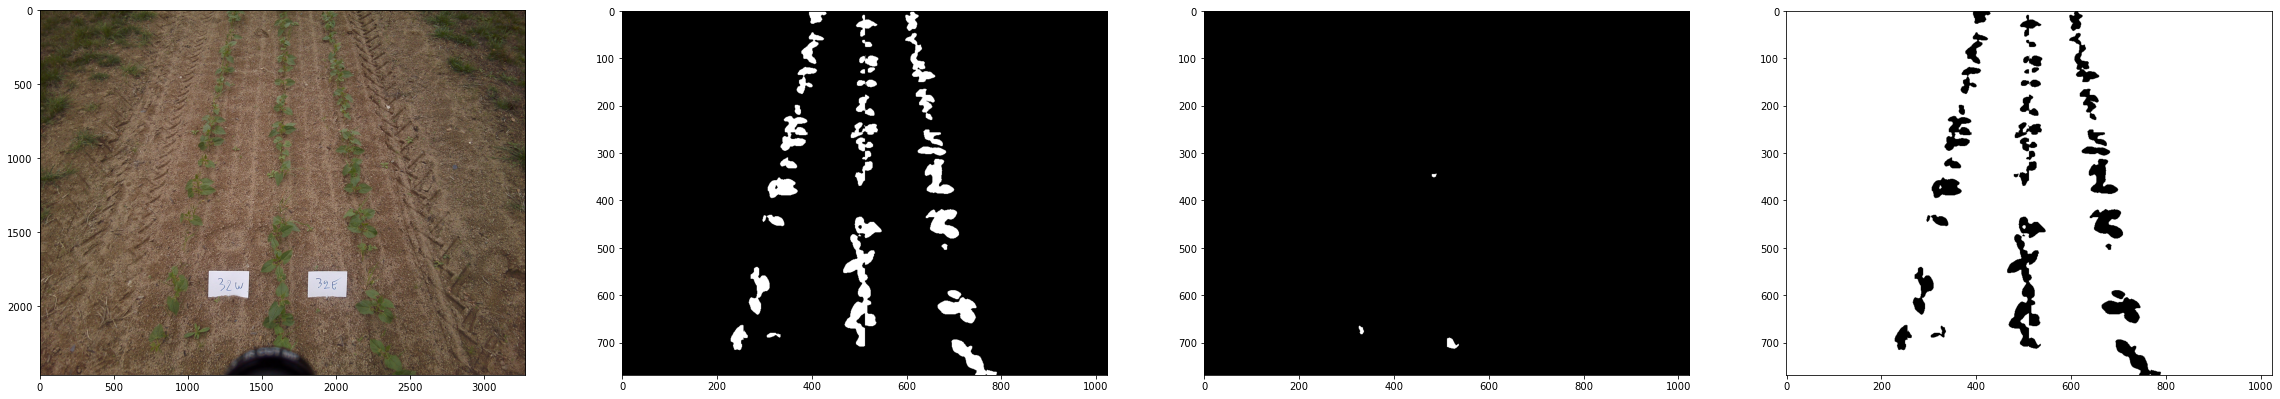

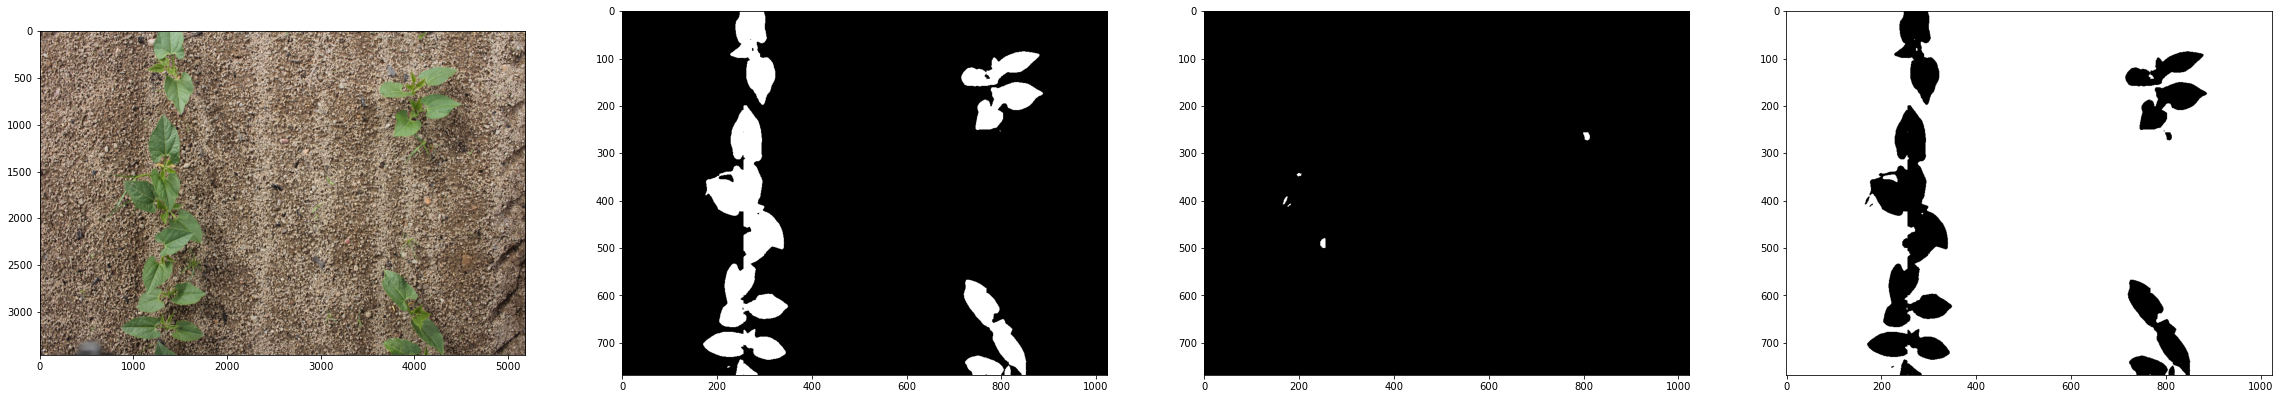

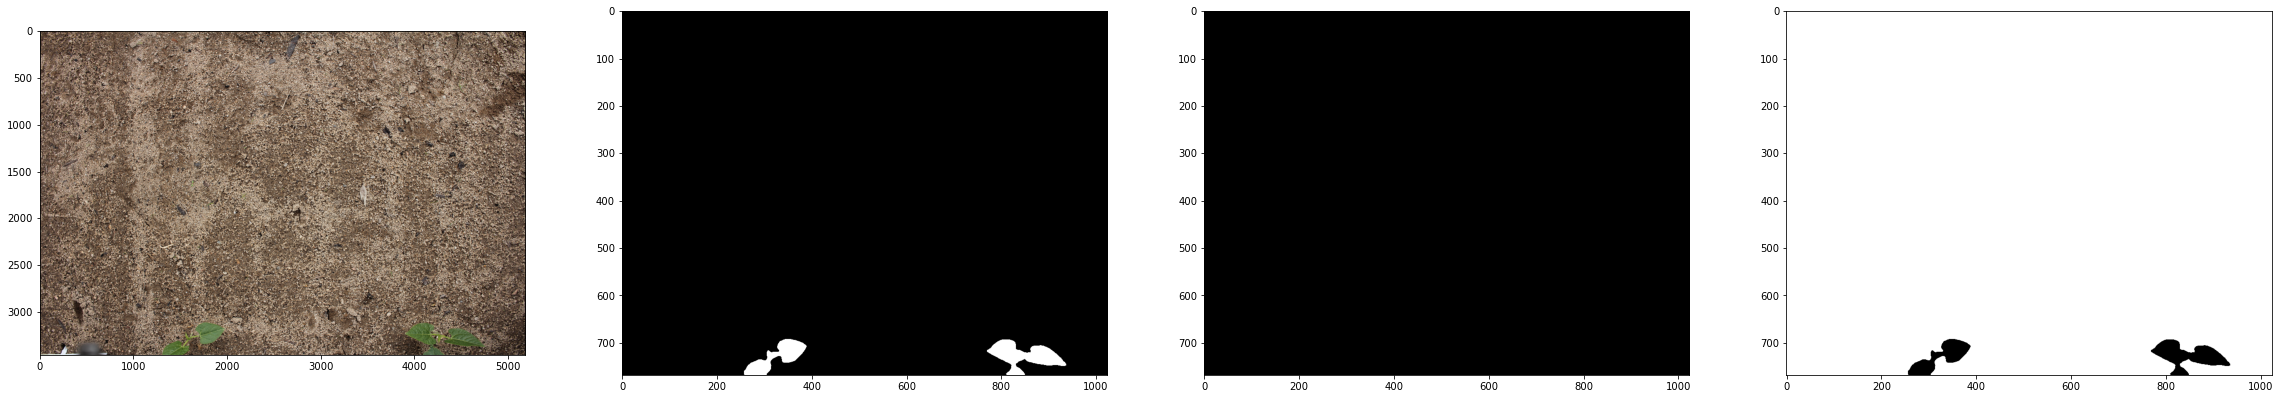

In [25]:
for i in np.random.choice(ds_test._indexes, 3):
    show(plt.imread(ds_test._paths_images[i]), recomposed_prediction[i][...,0], recomposed_prediction[i][...,1], recomposed_prediction[i][...,2])

### creation of the report

In [26]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Generates the **submission.json**

In [27]:
submission = {}
for m in ds_test._images_meta:
    resized_masks = cv.resize(recomposed_prediction[m.index], dsize=m.original_size[::-1], interpolation=cv.INTER_NEAREST)
    
    submission[m.path.stem] = {
        "shape": m.original_size,
        "crop": m.path.parents[1].stem,
        "team": m.path.parents[2].stem,
        "segmentation": {
            "crop": rle_encode(resized_masks[...,0]),
            "weed": rle_encode(resized_masks[...,1])
        }
    }

with open(PATH_SUBMISSION, "w") as file:
    json.dump(submission, file)

Zips the submission file for the submission

In [28]:
from zipfile import ZipFile
with ZipFile(PATH_SUBMISSION_ZIP, "w") as f:
    f.write(PATH_SUBMISSION, arcname = PATH_SUBMISSION.name)